# Natural Language Processing
## Fake News Detection 

In [1]:
# import libraries
import ftfy
import nltk
import json
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import csv
import numpy as np
import nltk
import seaborn as sb
import warnings

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Binarizer


from collections import Counter
from os import listdir, makedirs
from os.path import isfile, join, splitext, split

from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
#nltk.download('stopwords')


from wordcloud import STOPWORDS, WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.naive_bayes import GaussianNB

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier # need to import xboost calssifer

warnings.filterwarnings('ignore')
np.random.seed(0)

# Loading the LIAR Dataset
The dataset is in the format of 3 tab seperated files. Loading it as a pandas dataframe. Combining the train, test and validation files to a single file so that we can do the train and test split as required.

In [2]:
# Importing the dataset
train = pd.read_csv('train.tsv', delimiter='\t', quoting=3, header=None)
test = pd.read_csv('test.tsv', delimiter='\t', quoting=3, header=None)
valid = pd.read_csv('valid.tsv', delimiter='\t', quoting=3, header=None)

In [3]:
df_raw = pd.concat([train, test, valid], axis=0, sort=False)
df_raw = df_raw.sample(frac=1).reset_index()
df_raw.head(2)

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,8289,423.json,true,"""McCain opposes a woman's right to choose.""",abortion,moveon,NaN,NaN,democrat,2,4,3,0,0,an e-mail message
1,1156,10379.json,barely-true,The name Frank has risen in popularity by 20 p...,pop-culture,matt-lauer,Today Show host,NaN,none,1,0,0,0,0,a red carpet interview before the Golden Globes


In [4]:
# The file contains 12836 rows and 15 columns
df_raw.shape

(12836, 15)

In [5]:
# naming the columns of the dataset
df_raw.columns=["index","ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]

In [6]:
df_raw.head(2)

,index,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,8289,423.json,true,"""McCain opposes a woman's right to choose.""",abortion,moveon,NaN,NaN,democrat,2,4,3,0,0,an e-mail message
1,1156,10379.json,barely-true,The name Frank has risen in popularity by 20 p...,pop-culture,matt-lauer,Today Show host,NaN,none,1,0,0,0,0,a red carpet interview before the Golden Globes


In [7]:
# some of the statements
df_raw['statement'].head(10).tolist()

['"McCain opposes a woman\'s right to choose."',
 'The name Frank has risen in popularity by 20 percent since the debut of House of Cardson Netflix.',
 'Says Ted Cruz never denied his father was photographedwith Lee Harvey Oswald.',
 'Its been 14 years since a president or a vice president or a member of their family has not gone and attended at least an event at the Olympics.',
 'In the year 2013, the Obama administration released 104,000 criminal illegal aliens. They released 196 murderers people with homicide convictions, who are here illegally.',
 'Says the United States does not trade as much as other developed nations.',
 '"Oil companies ...currently have 68-million acres that they\'re not using."',
 'Says 24 million people in this country cant find a full-time job, 50 million cant see a doctor when theyre sick, 47 million people need government help to feed themselves and 15 million families owe more than the value of their home.',
 'President Obama went around the world and apo

In [8]:
# some of the speakers
df_raw['speaker'].head(20).tolist()

['moveon',
 'matt-lauer',
 'donald-trump',
 'candy-crowley',
 'ted-cruz',
 'rob-portman',
 'barack-obama',
 'alan-grayson',
 'mitt-romney',
 'joe-biden',
 'ellen-rosenblum',
 'linda-finn',
 'us-chamber-commerce',
 'tom-barrett',
 'chris-christie',
 'russell-edwards',
 'mitt-romney',
 'jeff-merkley',
 'rush-limbaugh',
 'john-boehner']

# Exploratory Data Analysis

Text(0.5, 1.0, 'Types & Number of Classes in the dataset')

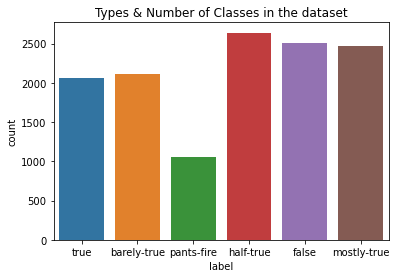

In [9]:
sns.countplot(x='label',data=df_raw)
plt.title('Types & Number of Classes in the dataset')

### Converting multiclass labels to two classes - Fake and True for exploratory data analysis

In [10]:
#function for mapping labels "true, mostly-true, half-true" to TRUE and "false, barely-true, pants-fire" to FAKE.
def binary_class_dataset(data):
    
    data = data.iloc[:, [2, 3]]
    data.columns = ['label', 'statement']
    Original_labels = {
        'true': 'True',
        'mostly-true': 'True',
        'half-true': 'True',
        'false': 'Fake',
        'barely-true': 'Fake',
        'pants-fire': 'Fake'
    }
    data['label'] = data['label'].map(Original_labels)

    return data

In [11]:
# running the function on the loaded dataframe
bi_class= binary_class_dataset(df_raw)

In [12]:
# new dataset with binary class labels - True and Fake substituted for the originals labels

bi_class.head(2)

,label,statement
0,True,"""McCain opposes a woman's right to choose."""
1,Fake,The name Frank has risen in popularity by 20 p...


## Creating Word Clouds for the text 'statements' in the LIAR dataset

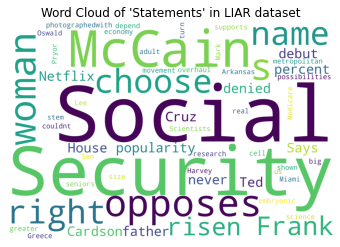

In [13]:
np.random.seed(0) # setting seed to get similar results over multiple experiments.

# word cloud for all the statements in the entire dataset
text = bi_class['statement'].values
wordcloud = WordCloud(width=3000, height=2000, background_color='white',stopwords=STOPWORDS).generate(str(text))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Word Cloud of 'Statements' in LIAR dataset")
plt.show()

In [14]:
# creating two dataset consisting of True and Fake statements seperately
np.random.seed(0)
true_statements_dataset = bi_class[bi_class['label'].astype(str) == 'True']
fake_statements_dataset = bi_class[bi_class['label'].astype(str) == 'Fake']

In [15]:
np.random.seed(0)
# contains only TRUE statements
true_statements_dataset.head(5)

,label,statement
0,True,"""McCain opposes a woman's right to choose."""
3,True,Its been 14 years since a president or a vice ...
4,True,"In the year 2013, the Obama administration rel..."
5,True,Says the United States does not trade as much ...
7,True,Says 24 million people in this country cant fi...


In [16]:
# contains only FAKE statements
np.random.seed(0)
fake_statements_dataset.head(5)

,label,statement
1,Fake,The name Frank has risen in popularity by 20 p...
2,Fake,Says Ted Cruz never denied his father was phot...
6,Fake,"""Oil companies ...currently have 68-million ac..."
8,Fake,President Obama went around the world and apol...
12,Fake,The new health care law crushes small business...


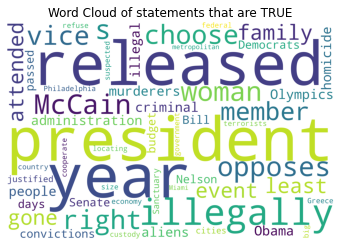

In [17]:
np.random.seed(0)
# creating word cloud for only those statements that are TRUE
text_true = true_statements_dataset['statement'].values
wordcloud_true = WordCloud(width=3000, height=2000, background_color='white',stopwords=STOPWORDS).generate(str(text_true))
plt.imshow(wordcloud_true)
plt.axis('off')
plt.title("Word Cloud of statements that are TRUE")
plt.show()

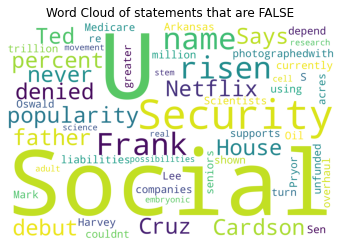

In [18]:
np.random.seed(0)
# creating word cloud for or only those statements that are FAKE
text_false = fake_statements_dataset['statement'].values
wordcloud_false = WordCloud(width=3000, height=2000, background_color='white',stopwords=STOPWORDS).generate(str(text_false))
plt.imshow(wordcloud_false)
plt.axis('off')
plt.title("Word Cloud of statements that are FALSE")
plt.show()

### Exploring the 'speakers' who have given the statements in the LIAR dataset

In [19]:
"""finding the total number of unique 'speakers' in the LIAR dataset"""
speakers_data = df_raw.copy()
speakers = speakers_data['speaker'].unique()

print("The total number of speakers in the LIAR dataset is : %d  " % len(speakers))
print()
print("Some sample speakers are:\n", speakers[:10].tolist())

The total number of speakers in the LIAR dataset is : 3318  

Some sample speakers are:
 ['moveon', 'matt-lauer', 'donald-trump', 'candy-crowley', 'ted-cruz', 'rob-portman', 'barack-obama', 'alan-grayson', 'mitt-romney', 'joe-biden']


In [20]:

""""displaying all the speakers in exploratory plot will not be possible nor meaningful.
            Hence finding the top speakers who have made frequent statements"""

speakers_cts = speakers_data.groupby("speaker").statement.count()
speakers = speakers_cts[speakers_cts > 100] # speakers who have made more than 100 statements.
print("There are %d speakers who have made statements more than 50 times in the dataset" % len(speakers))
print()
print("Some of the speakers and the number of statements made by them are:\n", speakers[:10])

There are 13 speakers who have made statements more than 50 times in the dataset

Some of the speakers and the number of statements made by them are:
 speaker
barack-obama       616
bernie-s           107
chain-email        178
chris-christie     105
donald-trump       344
hillary-clinton    297
john-mccain        189
marco-rubio        153
mitt-romney        216
rick-perry         173
Name: statement, dtype: int64


In [21]:
#Limiting ourselves to only prominent speakers for visualization
speakers_data = speakers_data[speakers_data['speaker'].isin(speakers.keys())]

In [22]:
"""function to groupby the speakers by the class and count of statements spoken by them"""

def class_counts(data, column):
    return data.groupby([column,"label"]).agg({"ID" : "count"})


#### Plot of top 13 speakers in the LIAR dataset labelled by class and count of statements they have given.

Text(0.5, 1.0, 'Top 13 speakers in the LIAR dataset with count and class of statements made')

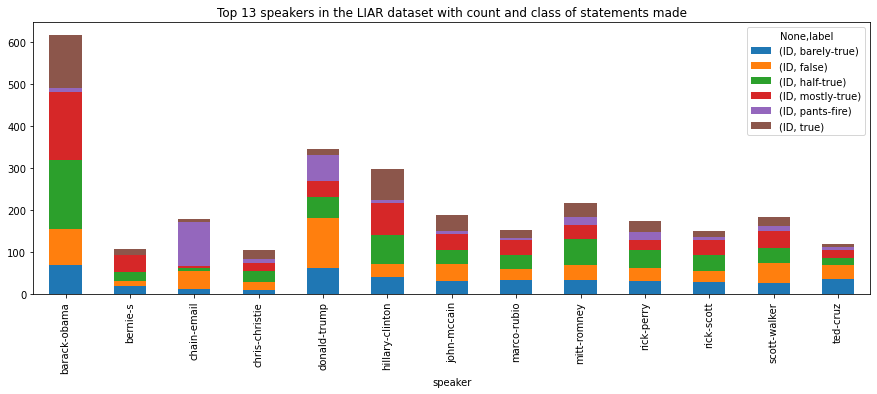

In [23]:
# stacked bar plot of speakrs with class and count of statements
breakdown = class_counts(speakers_data, 'speaker')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))
plt.title("Top 13 speakers in the LIAR dataset with count and class of statements made")

In [24]:
# Function for Normalising the statements and the speakers for comparison purpose

def normalize(data, column):
    norm = data.reset_index()
    norm = norm.set_index([column,'label'])['ID'].unstack(fill_value=0)

    row_totals = norm.sum(axis=1)
    for row in range(len(norm.index)):
        norm.iloc[row]/= row_totals[row]

    norm = norm.stack().reset_index(name='Percent').set_index([column, 'label'])
    return norm

#### Normalised plot of top 13 speakers in the LIAR dataset labelled type of statements they have given (for comparison)

Text(0.5, 1.0, 'Top 13 speakers in the LIAR dataset with count and class of statements made by them')

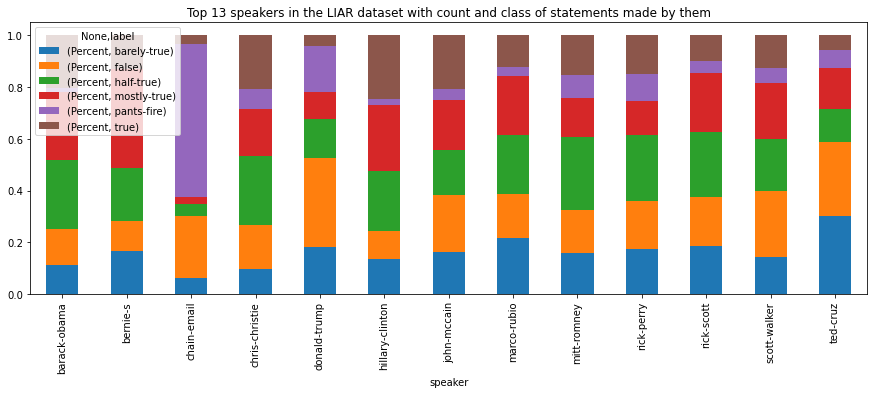

In [25]:
normalised_data = normalize(breakdown, 'speaker')
normalised_data.unstack().plot(kind='bar', stacked=True, figsize=(15,5))
plt.title("Top 13 speakers in the LIAR dataset with count and class of statements made by them")

From the above plot it can be seen that Facebook posts, Chain emails and Donald Trump have relatively higher number of 'pant-on_fire' fake statements compared to other speakers. We can also note that even though Obama made highest number of statements, his pant-on-fire statements are almost nill.

### Exploring the parties who have given statements in the LIAR dataset

In [26]:
# finding total number of parties in the LIAR dataset
parties_data = df_raw.copy()
parties = parties_data['party'].unique()
print("The total number of parties in LIAR dataset are : %d" % len(parties))
print()
print("Some  parties are:\n", parties.tolist())

The total number of parties in LIAR dataset are : 24

Some  parties are:
 ['democrat', 'none', 'republican', 'organization', 'journalist', 'newsmaker', 'independent', 'libertarian', 'state-official', 'columnist', 'activist', 'tea-party-member', 'labor-leader', 'talk-show-host', 'ocean-state-tea-party-action', 'business-leader', 'county-commissioner', 'constitution-party', 'government-body', 'education-official', 'democratic-farmer-labor', 'green', 'Moderate', 'liberal-party-canada']


In [27]:
# limiting the parties to those which have made frequent statements in the dataset.
parties_count = parties_data.groupby("party").statement.count()
parties = parties_count[parties_count > 20]     # more than 20 statements

print("Number of parties or entities who have made more than 20 statements in the LIAR dataset : %d" % len(parties))
print()
print("Some of the parties and number of statements made by them are :\n", parties[:10])

Number of parties or entities who have made more than 20 statements in the LIAR dataset : 12

Some of the parties and number of statements made by them are :
 party
activist          47
columnist         45
democrat        4150
independent      182
journalist        49
libertarian       51
newsmaker         66
none            2185
organization     265
republican      5687
Name: statement, dtype: int64


In [28]:
## Limiting ourselves to the top 12 parties in the LIAR dataset

parties_data = parties_data[parties_data['party'].isin(parties.keys())]

####  Plot of top 12 parties in the LIAR dataset labelled type of statements they have given

Text(0.5, 1.0, 'Top 12 parties/entities in the LIAR dataset with count and class of statements made by them')

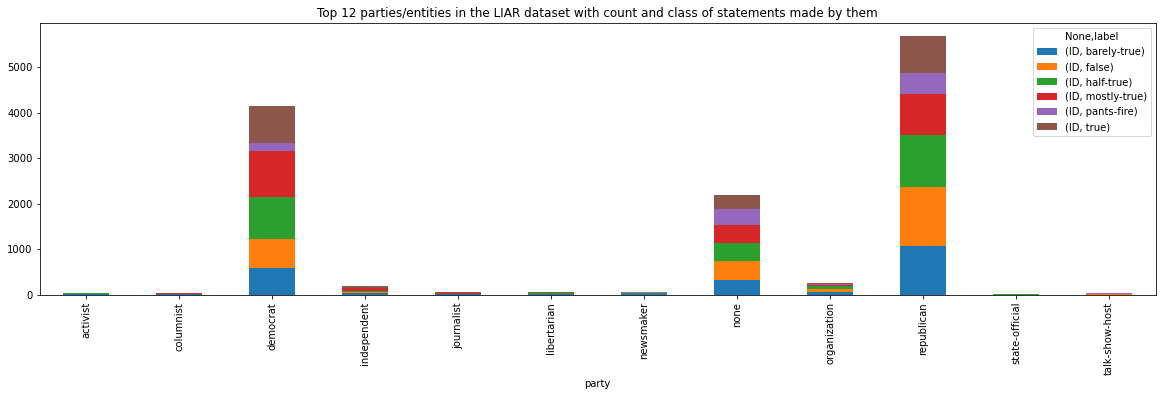

In [29]:
breakdown = class_counts(parties_data, 'party')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(20,5))
plt.title("Top 12 parties/entities in the LIAR dataset with count and class of statements made by them")

#### Normalised plot of top 12 parties in the LIAR dataset labelled type of statements they have given (for comparison)

Text(0.5, 1.0, 'Top 12 parties/entities in the LIAR dataset with count and class of statements made by them')

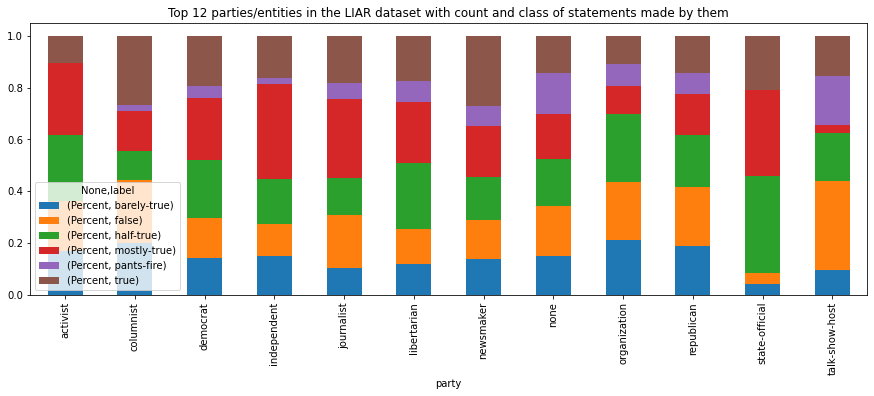

In [30]:
normalized_data = normalize(breakdown, 'party')
normalized_data.unstack().plot(kind='bar', stacked=True, figsize=(15,5))
plt.title("Top 12 parties/entities in the LIAR dataset with count and class of statements made by them")

# Using CountVectorizer for Extracting features from 'statements' in LIAR dataset

In [31]:
# specifying features and labels
X= df_raw['statement']
y=df_raw['label']

In [32]:
# sample statements
X.head(5).tolist()

['"McCain opposes a woman\'s right to choose."',
 'The name Frank has risen in popularity by 20 percent since the debut of House of Cardson Netflix.',
 'Says Ted Cruz never denied his father was photographedwith Lee Harvey Oswald.',
 'Its been 14 years since a president or a vice president or a member of their family has not gone and attended at least an event at the Olympics.',
 'In the year 2013, the Obama administration released 104,000 criminal illegal aliens. They released 196 murderers people with homicide convictions, who are here illegally.']

In [33]:
#sample labels
y.head(5)

0           true
1    barely-true
2     pants-fire
3           true
4      half-true
Name: label, dtype: object

In [34]:
# specifying train and test split with ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

10268 2568
10268 2568


### Custom Pre - Processing and Tokenisation of the data

In [35]:

""" Regular expression for cleaning the statements"""

hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")
extras_re = re.compile("[.;:!\'?,\"()\[\]]")
#apos_re = "\'[a-z]*"
#leftover_re = "\S+"

""" Preprocessing the text in the statements"""
def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = extras_re.sub("",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()

# regular expression for custom tokenisation"
tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)

# defining 3 types of tokenisation

def custom_tokenise(text):
    return tokenise_re.findall(text.lower())

def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words


def nltk_twitter_tokenise(text):
    twtok = nltk.tokenize.TweetTokenizer()
    return twtok.tokenize(text.lower())

# stop words list set to english
stopwords_list = stopwords.words('english') # stop word list



""" function for decontracting the statements"""
#def decontracted(phrase):
   # phrase = re.sub(r"won\'t", "will not", phrase)
   # phrase = re.sub(r"can\'t", "can not", phrase)
   # phrase = re.sub(r"n\'t", " not", phrase)
   # phrase = re.sub(r"\'re", " are", phrase)
   # phrase = re.sub(r"\'s", " is", phrase)
   # phrase = re.sub(r"\'d", " would", phrase)
    #phrase = re.sub(r"\'ll", " will", phrase)
    #phrase = re.sub(r"\'t", " not", phrase)
    #phrase = re.sub(r"\'ve", " have", phrase)
   # phrase = re.sub(r"\'m", " am", phrase)
    #return phrase

' function for decontracting the statements'

### Defining custom functions for displaying results of Classification

In [36]:
# function for results of cross-validation
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))


# fucntion for results of model fitting
def print_scores():
    print("Accuracy: ", accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    
# function for displaying confusion matrix
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (10, 8)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="BuPu", center=0, fmt='g')
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

# function for displaying confusion matrix in percentage terms
def confusion_matrix_percent_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    percents = cmdf.div(cmdf.sum(axis=1), axis=0)*100
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(percents, annot=True, cmap="PiYG", center=0, vmin=0, vmax=100)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75, 100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    
#list(df_columns.columns))-list(df_raw['labels'])"coolwarm"'Blues'PiYG'BuPu'

## Creating Pipeline with CountVectorizer with Custom preprocessing, Tokenisation, Stopwords, Normalistion (using TFIDTransformer), Feature selection and Logistic regression classifier

In [37]:
model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list)),
    ('norm2', TfidfTransformer(norm=None)),
    ('selector', SelectKBest(chi2, k=1000)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [38]:
# fitting the model
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores() # using the predefined function to display results of the classification

Accuracy:  0.24182242990654207
              precision    recall  f1-score   support

 barely-true       0.25      0.17      0.20       422
       false       0.22      0.40      0.28       502
   half-true       0.24      0.25      0.25       528
 mostly-true       0.26      0.25      0.25       493
  pants-fire       0.32      0.15      0.20       210
        true       0.26      0.15      0.19       413

    accuracy                           0.24      2568
   macro avg       0.26      0.23      0.23      2568
weighted avg       0.25      0.24      0.23      2568

[[ 71 162  85  64  17  23]
 [ 59 202 109  76  18  38]
 [ 60 172 134  94  15  53]
 [ 32 158 120 121   9  53]
 [ 28  84  39  19  31   9]
 [ 29 146  75  93   8  62]]


In [39]:
# limiting the max features to 1000 and checking the model
model.set_params(vectorizer__max_features=1000)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=1000,
                                 preprocessor=<function preprocess at 0x0000024E6991DAF0>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function Tokenizer at 0x0000024E6A0E78B0>)),
                ('norm2', TfidfTransformer(norm=None)),
                ('selector',
                 SelectKBest(k=1

In [40]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()
# the accuracy is reduced so reverting back without setting max features

Accuracy:  0.23870716510903428
              precision    recall  f1-score   support

 barely-true       0.23      0.20      0.22       422
       false       0.25      0.30      0.27       502
   half-true       0.24      0.24      0.24       528
 mostly-true       0.27      0.27      0.27       493
  pants-fire       0.19      0.17      0.18       210
        true       0.21      0.21      0.21       413

    accuracy                           0.24      2568
   macro avg       0.23      0.23      0.23      2568
weighted avg       0.24      0.24      0.24      2568

[[ 84 113  79  62  29  55]
 [ 70 149  92  71  48  72]
 [ 71 103 125 107  36  86]
 [ 63  86  91 132  22  99]
 [ 32  58  45  21  36  18]
 [ 39  87  90  88  22  87]]


#### Using Binarizer for normalisation instead of TfidfTransformer (i.e. scale to 0 for not present or 1 for present at any frequency), this is useful when documents are shorts as 'statements' in LIAR dataset

In [41]:

model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list)),
    ('norm', Binarizer()),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [42]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()


Accuracy:  0.2472741433021807
              precision    recall  f1-score   support

 barely-true       0.25      0.23      0.24       422
       false       0.24      0.28      0.26       502
   half-true       0.27      0.30      0.28       528
 mostly-true       0.25      0.25      0.25       493
  pants-fire       0.24      0.14      0.17       210
        true       0.23      0.21      0.22       413

    accuracy                           0.25      2568
   macro avg       0.24      0.23      0.24      2568
weighted avg       0.25      0.25      0.25      2568

[[ 98 100  94  60  23  47]
 [ 82 140  96  89  28  67]
 [ 67 100 157 103  19  82]
 [ 71  98 108 123   8  85]
 [ 41  57  46  21  29  16]
 [ 35  88  83 104  15  88]]


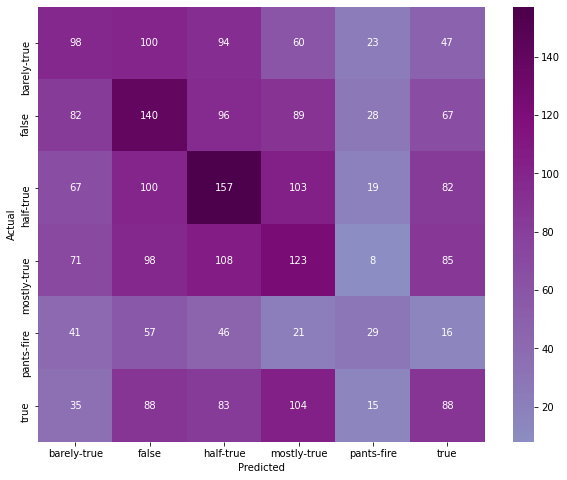

In [43]:
confusion_matrix_heatmap(confusion_matrix(y_test,predictions), model.classes_)

In [44]:
# code to view the selected features
vectorizer = CountVectorizer(analyzer='word')
selector = SelectKBest(chi2, k=100)
feats = vectorizer.fit_transform(X_train)
filtered = selector.fit_transform(feats, y_train)

In [45]:
from itertools import compress
cols = selector.get_support()
names = vectorizer.get_feature_names()

print(list(compress(names,cols)))

['000', '10', '247', 'and', 'average', 'bachmann', 'barack', 'beliefs', 'blue', 'border', 'bulbs', 'care', 'country', 'cross', 'cut', 'debunked', 'duffy', 'face', 'georgia', 'gov', 'half', 'hillary', 'in', 'increased', 'jersey', 'jobs', 'kenyan', 'kloppenburgs', 'landrieu', 'last', 'less', 'lowest', 'lying', 'mcauliffe', 'mccain', 'meat', 'michelle', 'million', 'monument', 'more', 'mormon', 'muslim', 'muslims', 'nose', 'obama', 'obamacare', 'obamas', 'of', 'ops', 'oswald', 'outbreak', 'outlaws', 'percent', 'photographed', 'plan', 'poverty', 'president', 'prisons', 'protein', 'radar', 'rate', 'rep', 'reps', 'retiree', 'richest', 'riot', 'rugs', 'says', 'scheme', 'scott', 'sean', 'sharia', 'sic', 'since', 'socialists', 'society', 'spending', 'sporting', 'states', 'stimulus', 'supports', 'takeover', 'than', 'the', 'three', 'to', 'today', 'top', 'transactions', 'unelected', 'walker', 'wash', 'we', 'wic', 'will', 'wisconsin', 'wording', 'words', 'year', 'your']


In [46]:
# Using Multinomial Naive Bayes classifier
model.set_params(clf=MultinomialNB())

Pipeline(steps=[('vectorizer',
                 CountVectorizer(preprocessor=<function preprocess at 0x0000024E6991DAF0>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function Tokenizer at 0x0000024E6A0E78B0>)),
                ('norm', Binarizer()), ('clf', MultinomialNB())])

In [47]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.24805295950155765
              precision    recall  f1-score   support

 barely-true       0.23      0.21      0.22       422
       false       0.23      0.23      0.23       502
   half-true       0.25      0.36      0.29       528
 mostly-true       0.27      0.33      0.30       493
  pants-fire       0.30      0.08      0.13       210
        true       0.24      0.15      0.18       413

    accuracy                           0.25      2568
   macro avg       0.25      0.23      0.23      2568
weighted avg       0.25      0.25      0.24      2568

[[ 90  93 122  73  12  32]
 [ 84 117 140 100  12  49]
 [ 70  93 191 115  10  49]
 [ 62  73 144 161   3  50]
 [ 43  60  54  24  17  12]
 [ 36  68 125 120   3  61]]


In [48]:
# Fitting C-Support Vector Classifier
model.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=1000))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.23325545171339565
              precision    recall  f1-score   support

 barely-true       0.20      0.25      0.22       422
       false       0.24      0.28      0.26       502
   half-true       0.27      0.27      0.27       528
 mostly-true       0.25      0.22      0.23       493
  pants-fire       0.21      0.16      0.18       210
        true       0.22      0.17      0.19       413

    accuracy                           0.23      2568
   macro avg       0.23      0.22      0.23      2568
weighted avg       0.23      0.23      0.23      2568

[[104 108  88  51  26  45]
 [117 141  74  74  39  57]
 [105  94 141  93  31  64]
 [ 94  98 107 109  11  74]
 [ 53  58  33  18  33  15]
 [ 59  98  80  90  15  71]]


In [49]:
# fitting Decision tree classifier
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
model.set_params(clf=decision_tree)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.23208722741433022
              precision    recall  f1-score   support

 barely-true       0.20      0.18      0.19       422
       false       0.27      0.32      0.30       502
   half-true       0.24      0.24      0.24       528
 mostly-true       0.24      0.25      0.25       493
  pants-fire       0.15      0.13      0.14       210
        true       0.21      0.20      0.20       413

    accuracy                           0.23      2568
   macro avg       0.22      0.22      0.22      2568
weighted avg       0.23      0.23      0.23      2568

[[ 76 103  91  72  28  52]
 [ 80 162  88  77  36  59]
 [ 67 111 126 108  36  80]
 [ 60  99  89 124  27  94]
 [ 36  49  37  39  27  22]
 [ 55  71  90  91  25  81]]


In [50]:
# fitting Random forest classifier
model.set_params(clf=RandomForestClassifier(random_state=1000))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.25272585669781933
              precision    recall  f1-score   support

 barely-true       0.24      0.14      0.18       422
       false       0.25      0.44      0.32       502
   half-true       0.26      0.26      0.26       528
 mostly-true       0.26      0.29      0.27       493
  pants-fire       0.42      0.10      0.17       210
        true       0.21      0.15      0.18       413

    accuracy                           0.25      2568
   macro avg       0.27      0.23      0.23      2568
weighted avg       0.26      0.25      0.24      2568

[[ 59 149  99  75   7  33]
 [ 50 223  94  73  10  52]
 [ 56 146 139 120   6  61]
 [ 35 132 100 142   6  78]
 [ 25  85  38  27  22  13]
 [ 24 146  70 107   2  64]]


In [51]:
# fitting X-gradient boost algorithm
model.set_params(clf=XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

[23:12:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.23870716510903428
              precision    recall  f1-score   support

 barely-true       0.21      0.11      0.15       422
       false       0.23      0.43      0.30       502
   half-true       0.25      0.29      0.27       528
 mostly-true       0.24      0.26      0.25       493
  pants-fire       0.29      0.05      0.09       210
        true       0.24      0.13      0.17       413

    accuracy                           0.24      2568
   macro avg       0.24      0.21      0.20      2568
weighted avg       0.24      0.24      0.22      2568

[[ 47 159 106  81   6  23]
 [ 49 218 104  88   9  34]
 [ 51 161 152 106   8  50]
 [ 30 139 128 130   2  64]
 [ 25 1

## Cross validating the best models from CountVectorizer Pipeline - Logistic regression and Multinomial Guassian NB

In [52]:
model.set_params(clf= LogisticRegression(solver='liblinear', random_state=0))

Pipeline(steps=[('vectorizer',
                 CountVectorizer(preprocessor=<function preprocess at 0x0000024E6991DAF0>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function Tokenizer at 0x0000024E6A0E78B0>)),
                ('norm', Binarizer()),
                ('clf',
                 LogisticRegression(random_state=0, solver='liblinear'))])

In [53]:

cv_scores = cross_validate(model, X, y, 
                           cv=StratifiedKFold(n_splits=5, random_state=None), 
                           return_train_score=True, 
                           scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
                          )

In [54]:
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

Accuracy: mean = 24.21%, sd = 1.01%, min = 22.94, max = 25.40
Precision: mean = 24.20%, sd = 1.01%, min = 22.88, max = 25.37
Recall: mean = 24.21%, sd = 1.01%, min = 22.94, max = 25.40
F1: mean = 24.00%, sd = 1.02%, min = 22.77, max = 25.20


In [55]:
model.set_params(clf=MultinomialNB())

Pipeline(steps=[('vectorizer',
                 CountVectorizer(preprocessor=<function preprocess at 0x0000024E6991DAF0>,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function Tokenizer at 0x0000024E6A0E78B0>)),
                ('norm', Binarizer()), ('clf', MultinomialNB())])

In [56]:
cv_scores = cross_validate(model, X, y, 
                           cv=StratifiedKFold(n_splits=5, random_state=None), 
                           return_train_score=False, 
                           scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
                          )

In [57]:
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

Accuracy: mean = 24.32%, sd = 0.65%, min = 23.61, max = 25.32
Precision: mean = 24.46%, sd = 0.77%, min = 23.40, max = 25.28
Recall: mean = 24.32%, sd = 0.65%, min = 23.61, max = 25.32
F1: mean = 23.42%, sd = 0.65%, min = 22.73, max = 24.42


### Replacing 'word' with char_wb(which counts characters within words) and ngrams range of 1-3 in the pipeline.

In [58]:
model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char_wb',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list, ngram_range=(1,3))),
    ('norm', Binarizer()),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [59]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()



Accuracy:  0.21378504672897197
              precision    recall  f1-score   support

 barely-true       0.18      0.18      0.18       422
       false       0.22      0.24      0.23       502
   half-true       0.25      0.26      0.25       528
 mostly-true       0.24      0.25      0.25       493
  pants-fire       0.15      0.12      0.13       210
        true       0.19      0.17      0.18       413

    accuracy                           0.21      2568
   macro avg       0.20      0.20      0.20      2568
weighted avg       0.21      0.21      0.21      2568

[[ 77  87 100  74  31  53]
 [105 119  87  77  48  66]
 [ 82  97 136 103  25  85]
 [ 72  79 115 121  22  84]
 [ 39  57  41  27  26  20]
 [ 56  93  75  92  27  70]]


In [60]:
model.set_params(clf=MultinomialNB())
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()


Accuracy:  0.24182242990654207
              precision    recall  f1-score   support

 barely-true       0.22      0.21      0.22       422
       false       0.24      0.28      0.26       502
   half-true       0.28      0.23      0.25       528
 mostly-true       0.26      0.27      0.26       493
  pants-fire       0.20      0.25      0.22       210
        true       0.24      0.20      0.22       413

    accuracy                           0.24      2568
   macro avg       0.24      0.24      0.24      2568
weighted avg       0.24      0.24      0.24      2568

[[ 89 107  67  74  47  38]
 [ 81 140  76  77  71  57]
 [ 76 104 122 117  41  68]
 [ 65  93  83 134  31  87]
 [ 40  58  24  18  53  17]
 [ 48  90  63 102  27  83]]


In [61]:
model.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=1000))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.2044392523364486
              precision    recall  f1-score   support

 barely-true       0.16      0.23      0.19       422
       false       0.23      0.25      0.24       502
   half-true       0.24      0.23      0.23       528
 mostly-true       0.23      0.19      0.21       493
  pants-fire       0.15      0.14      0.15       210
        true       0.19      0.14      0.16       413

    accuracy                           0.20      2568
   macro avg       0.20      0.20      0.20      2568
weighted avg       0.21      0.20      0.20      2568

[[ 96  98  84  73  36  35]
 [135 126  74  69  45  53]
 [121 104 121  85  32  65]
 [102  92 106  95  26  72]
 [ 57  51  35  22  30  15]
 [ 79  89  89  70  29  57]]


In [62]:
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
model.set_params(clf=decision_tree)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.2091121495327103
              precision    recall  f1-score   support

 barely-true       0.18      0.19      0.18       422
       false       0.26      0.26      0.26       502
   half-true       0.24      0.24      0.24       528
 mostly-true       0.20      0.21      0.21       493
  pants-fire       0.10      0.10      0.10       210
        true       0.20      0.18      0.19       413

    accuracy                           0.21      2568
   macro avg       0.20      0.20      0.20      2568
weighted avg       0.21      0.21      0.21      2568

[[ 79  75  89  82  39  58]
 [ 80 132 100  93  41  56]
 [108  92 128  98  28  74]
 [ 81  88  90 105  43  86]
 [ 41  39  49  43  20  18]
 [ 57  82  77  93  31  73]]


In [63]:
model.set_params(clf=RandomForestClassifier(random_state=1000))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.2632398753894081
              precision    recall  f1-score   support

 barely-true       0.27      0.18      0.22       422
       false       0.27      0.41      0.33       502
   half-true       0.24      0.33      0.28       528
 mostly-true       0.26      0.31      0.28       493
  pants-fire       0.41      0.03      0.06       210
        true       0.29      0.14      0.19       413

    accuracy                           0.26      2568
   macro avg       0.29      0.23      0.23      2568
weighted avg       0.28      0.26      0.25      2568

[[ 78 120 120  79   4  21]
 [ 60 207 126  85   3  21]
 [ 63 125 176 128   1  35]
 [ 28 114 143 151   1  56]
 [ 26  79  57  35   7   6]
 [ 35 119 100 101   1  57]]


In [64]:
model.set_params(clf=XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

[23:26:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.2542834890965732
              precision    recall  f1-score   support

 barely-true       0.25      0.15      0.19       422
       false       0.25      0.43      0.32       502
   half-true       0.27      0.34      0.30       528
 mostly-true       0.24      0.26      0.25       493
  pants-fire       0.21      0.04      0.07       210
        true       0.26      0.15      0.19       413

    accuracy                           0.25      2568
   macro avg       0.25      0.23      0.22      2568
weighted avg       0.25      0.25      0.24      2568

[[ 63 126 125  80   8  20]
 [ 52 215  97  87  15  36]
 [ 46 145 177 106   5  49]
 [ 42 140 121 126   4  60]
 [ 29  8

## Grid search CV with top_k from chi squared feature selection set to different values and top 2 performing classifiers with CountVectorizer 

In [ ]:
model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list, ngram_range=(1,3))),
    ('norm', Binarizer()),
    ('selector', SelectKBest(score_func = chi2)),
    ('clf', LogisticRegression(solver='liblinear', random_state=None)),
])

search = GridSearchCV(model, cv=StratifiedKFold(n_splits=5, random_state=None), 
                      return_train_score=False, 
                      scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid={
                          'selector__k': [10, 50, 100, 250, 500, 1000],
                          'clf': [MultinomialNB(), XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=None)],
                      })

search.fit(X_train, y_train)

In [ ]:
pd.DataFrame(search.cv_results_)

In [ ]:
# results of the best fit classifier
predictions = search.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(y_test,predictions), search.classes_)

In [ ]:
print(search.best_estimator_ )

In [ ]:
search.best_score_

In [ ]:
print(search.best_params_)

In [ ]:
print(search.scorer_)

## Creating Pipeline with TFID Vectorizer along with Feature Union of 'total words' in the 'statements'


TF-IDF - stands for “Term Frequency — Inverse Document”. Term Frequency summarizes how often a given word appears within a document.Inverse Document Frequency scales words that appear a lot across documents.TF-IDF highlight words that are more interesting, e.g. frequent in a document but not across documents.

However in this instance we use feature union as well by incorporating the total words in each sentence as another feature. We build a custom transformer with two classes for features in the statements and the total number of words in the statements. By setting min\_df to 0.25 and max\_df to 0.75 we restrict the terms in the vocabulary based on document frequency

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.field]]

In [ ]:
df_raw_tfid= df_raw.copy()

In [ ]:
df_raw_tfid.head(2)

In [ ]:
header_list=["index","ID", "label", "statement","TotalWords","Lemmatised_words", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]

In [ ]:
df_raw_tfid = df_raw_tfid.reindex(columns = header_list) 

In [ ]:
# creating new column to hold total number of words in the statements and calculating the total words
df_raw_tfid['TotalWords'] = df_raw_tfid['statement'].str.split().str.len()

In [ ]:
df_raw_tfid.head(2)

In [ ]:
X = df_raw_tfid[['statement', 'TotalWords']]

Y = df_raw_tfid['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

## Creating the pipeline with TFIDVectorizer and feature union of total words in statements

In [ ]:
classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('statement')),
            ('tfidf', TfidfVectorizer(analyzer='word',preprocessor=preprocess, tokenizer=Tokenizer, stop_words=stopwords_list,
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
    ])



In [ ]:
# logistic regression
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()



In [ ]:
confusion_matrix_heatmap(confusion_matrix(y_test, predictions), classifier.classes_)

In [ ]:
#becasue multinominal naive baiese deosnt fit
classifier.set_params(clf=GaussianNB())
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

In [ ]:
classifier.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=1000))
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

In [ ]:
#highest accuracy 
confusion_matrix_heatmap(confusion_matrix(y_test,predictions), classifier.classes_)

In [ ]:
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
classifier.set_params(clf=decision_tree)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

In [ ]:
classifier.set_params(clf=RandomForestClassifier(random_state=1000))
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

In [ ]:
classifier.set_params(clf=XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0))
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

## Using char_wb for the TFIDVectorizer and features union

In [ ]:
classifier_char_wb = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('statement')),
            ('tfidf', TfidfVectorizer(analyzer='char_wb',preprocessor=preprocess, tokenizer=Tokenizer, stop_words=stopwords_list,
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf', LogisticRegression(solver='liblinear', random_state=1000)),
    ])

In [ ]:
#logistic regression
classifier_char_wb.fit(X_train, y_train)
predictions = classifier_char_wb.predict(X_test)
print_scores()

In [ ]:
# Gaussian NB
classifier_char_wb.set_params(clf=GaussianNB())
classifier_char_wb.fit(X_train, y_train)
predictions = classifier_char_wb.predict(X_test)
print_scores()

In [ ]:
#Support vector Machine classifier
classifier_char_wb.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))
classifier_char_wb.fit(X_train, y_train)
predictions = classifier_char_wb.predict(X_test)
print_scores()

In [ ]:
#decision tree
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
classifier_char_wb.set_params(clf=decision_tree)
classifier_char_wb.fit(X_train, y_train)
predictions = classifier_char_wb.predict(X_test)
print_scores()

In [ ]:
classifier_char_wb.set_params(clf=RandomForestClassifier())
classifier_char_wb.fit(X_train, y_train)
predictions = classifier_char_wb.predict(X_test)
print_scores()

In [ ]:
classifier_char_wb.set_params(clf=XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0))
classifier_char_wb.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print_scores()

### Grid Search CV with TFIDVectorizer, feature Union and top 2 performing classifiers

In [ ]:
classifier_grid = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('statement')),
            ('tfidf', TfidfVectorizer(analyzer='word', preprocessor=preprocess, tokenizer=Tokenizer, stop_words='english',
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf',None),
    ])
    
param_grid={
   # 'selector__k': [100, 50,150],
    'clf': [LogisticRegression(solver='liblinear', random_state=0),svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'),
    svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'),RandomForestClassifier() ],
}


In [ ]:
search = GridSearchCV(classifier_grid, cv = StratifiedKFold(n_splits=5, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid)

search.fit(X_train, y_train)
 

In [ ]:
pd.DataFrame(search.cv_results_)

In [ ]:
predictions = search.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(y_test,predictions), search.classes_)

In [ ]:
confusion_matrix_percent_heatmap(confusion_matrix(y_test,predictions), search.classes_)

In [ ]:
print(search.best_estimator_ )

In [ ]:
search.best_score_

In [ ]:
print(search.best_params_) 

In [ ]:
print(search.scorer_)

## Lemmatisation of the 'statements' by giving POS (parts of speech) Tags as context

> Earlier we did stemming of the 'statements' in the LIAR dataset using NLTK porter stemmer. Now we use stemming.The aim of both is the similar that is to reduce the inflectional forms of each word into a common base or root. Lemmatization is closely related to stemming, However the difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. Here we provide POS (parts of speech tagging) as the context for lemmatisation. Stemmers are typically easier to implement and run faster but have reduced accuracy.


In [ ]:
"""WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc.
        By default it is set to Noun. Here we consider only POS tags of Noun, Adjective, Verb and Adverb. """

corpus=[]

for state in df_raw_tfid['statement']:
    
    texts=preprocess(state)
    token=nltk.word_tokenize(texts)
    corpus.append(token)

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(corpus):
    # looping through the entries and saving in the corpus
    Final_words = []
    # fitting WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag will provide the 'tag' i.e if the word is Noun(N) or Verb(V) etc.
    for word, tag in pos_tag(entry):
        # condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The processed words for each 'statement' will be store in column 'lemmatised_words in the dataframe'
    df_raw_tfid.loc[index,'Lemmatised_words'] = str(Final_words)

In [ ]:
# sample lemmatised text of the 'statements'
corpus[1:2]

In [ ]:
# We can see that new column 'Lemmtised_words is created which stores the lemmatised words of the 'statements'
df_raw_tfid.head(2)

In [ ]:
X=df_raw_tfid['Lemmatised_words'].tolist()
y=df_raw_tfid['label']

In [ ]:
# fitting TfidfVectorizer with the lemmatised 'statements'
Encoder = LabelEncoder()
y = Encoder.fit_transform(y)

Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(df_raw_tfid['Lemmatised_words'])
X = Tfidf_vect.transform(X)

In [ ]:
# logistic regression classifier
logistic = LogisticRegression(solver='liblinear', random_state=0)

In [ ]:
# cross validation
cv_scores = cross_validate(logistic, X, y, cv=StratifiedKFold(n_splits=5, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])



In [ ]:
#confusion_matrix_heatmap(confusion_matrix(y_test,predictions), search.classes_)

In [ ]:
SVM_classifier=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=0)

In [ ]:
cv_scores = cross_validate(SVM_classifier, X, y, cv=StratifiedKFold(n_splits=5, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])


In [ ]:
XGradientBoost= XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0)

In [ ]:
cv_scores = cross_validate(XGradientBoost, X, y, cv=StratifiedKFold(n_splits=5, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])


## Converting the Multiclass labels into Binary class labels (Fake & True) and predicting

In [ ]:
bi_class.head(2)

In [ ]:
bi_class['TotalWords'] = bi_class['statement'].str.split().str.len()

In [ ]:
bi_class.head(2)

In [ ]:
X = bi_class[['statement', 'TotalWords']]

Y=  bi_class['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [ ]:

classifier_biclass = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('colext', TextSelector('statement')),
            ('tfidf', TfidfVectorizer(analyzer='word',preprocessor=preprocess, tokenizer=Tokenizer, stop_words=stopwords_list,
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([
            ('wordext', NumberSelector('TotalWords')),
            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
    ])

In [ ]:
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()

In [ ]:
matrix=confusion_matrix(y_test, predictions) # getting the results of confusion matrix from the classification.
sns.heatmap(matrix, annot = True,fmt='g')       # printing the matrix
plt.title('Logistic Regression binary class Confusion-Matrix')
plt.ylabel('True labels')
plt.xlabel('Predicted labels');

In [ ]:
classifier_biclass.set_params(clf=GaussianNB())
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()

In [ ]:
classifier.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()

In [ ]:
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
classifier.set_params(clf=decision_tree)
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()

In [ ]:
classifier.set_params(clf=RandomForestClassifier())
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()

In [ ]:
classifier.set_params(clf=XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, random_state=0))
classifier_biclass.fit(X_train, y_train)
predictions = classifier_biclass.predict(X_test)
print_scores()